# Introduction 
Airline Passenger Satisfaction - Classical prediction Analysis using Machine Learning Models

The dataset is basically a survey data taken from around 130k passengers based on U.S airlines.

Research questions

1.Can we predict customer satisfaction given the survey data of airline.
2.What factors must the airlines consider to achieve the satisfaction level of its customers and to improve customer base ?

The focus is thus on applying machine learning models using classical predictive analysis and evaluate the models to determine the best fitting algorithm.
The dataset was already split into train and test csv files.But I have concatenated it to get my own 80% of the total dataset as train data and 20% as test data.

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection
from sklearn import neighbors
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import Lasso ,lars_path 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score


In [2]:
#Import and read data 
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train.shape

(103904, 25)

In [4]:
test.shape

(25976, 25)

In [5]:
#Concatenating both csv files into one 

frames = [train,test]

df = pd.concat(frames)

In [6]:
df.shape

(129880, 25)

In [7]:
#Features in the dataset
df.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

Data Cleaning/Wrangling

The data has to be analyzed, cleaned up (dropping unnecessary columns ,data Vs Data type mismatch,handling missing data and one-hot encoding) before it can be used in a model.
Summary of what has been done:
1. "Ünnamed" and "Id"columns dropped as they aren't of any use.
2.  Missing values in "Ärrival delay in minutes" replaced with the average delay time.
3. "Eco Plus" value in Customer Type renamed as "Economy"
4. "Ärrival delay in minutes" and "Departure delay in minutes" combined into one - "Total Delay" as both are highly correlated to each other.

In [8]:
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [9]:
# Fields Unnamed : 0' and 'id' are not going to be used. Hence drop that column.
df.drop(columns = ['Unnamed: 0','id'] , axis=1,inplace=True)

In [10]:
# Handling Missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df.head()

,Total,Percent
Arrival Delay in Minutes,393,0.003026
satisfaction,0,0.000000
Food and drink,0,0.000000
Customer Type,0,0.000000
Age,0,0.000000


'Arrival delay in minutes' has 393 missing values which accounts for about 3% of the total values.
Inorder not to impact the model performance , I'll fill these missing values with the average delay time .

In [11]:
# Filling missing values with mean
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(np.mean(df['Arrival Delay in Minutes']))

In [12]:
#Eco-Plus can also be considered as Economy itself.
df['Class'] = df['Class'].map({'Eco':'Economy','Eco Plus':'Economy','Business':'Business'})

In [13]:
# Features Arrival delay and Departure delay can be combined into one as "Total Delay"
df['Total Delay'] = df['Departure Delay in Minutes'] + df['Arrival Delay in Minutes']
df = df.reindex(columns=['satisfaction']+list(df.columns)[:-2]+['Total Delay'])
df = df.drop(['Departure Delay in Minutes','Arrival Delay in Minutes'],axis=1)

In [14]:
#Let's check the data types of all the columns to see if there are any of them inappropriately defined and correct it accordingly.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 25975
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Inflight wifi service              129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Ease of Online booking             129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Food and drink                     12988

In [15]:
#Now let's look at the data again
df.head(5)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Total Delay
0,neutral or dissatisfied,Male,Loyal Customer,13,Personal Travel,Economy,460,3,4,3,...,3,5,5,4,3,4,4,5,5,43.0
1,neutral or dissatisfied,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,3,1,1,1,5,3,1,4,1,7.0
2,satisfied,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,5,5,4,3,4,4,4,5,0.0
3,neutral or dissatisfied,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,2,2,5,3,1,4,2,20.0
4,satisfied,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,5,5,3,3,4,4,3,3,3,0.0


# Exploratory Data Analysis and Feature Selection
We need to analyze the data further to find out which features can strongly influence the prediction of our target variable : "satisfaction" so that we can choose the ML algorithms appropriately.
We will have to remove features which have high collinearity or those which have a negative impact on prediction. Before that we need to understand the trends in the data with the help of some visualizations.

#### Firstly how many passengers are satisfied/dissatisfied? Do we have more unsatisfied passengers?

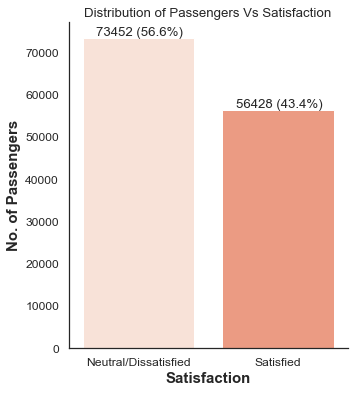

In [16]:
sns.set(style='white',font_scale=1.1)
fig = plt.figure(figsize=[5,6])
ax = sns.countplot(data=df,x='satisfaction',palette=["#fee0d2","#fc9272"])
ax.set_xticklabels(['Neutral/Dissatisfied','Satisfied'])
for p in ax.patches:
        ax.annotate(str(p.get_height())+' ('+str((p.get_height()/len(df)*100).round(1))+'%)', (p.get_x()+0.1, p.get_height()+400))
plt.xlabel('Satisfaction',weight='bold',fontsize='15')   
plt.ylabel('No. of Passengers',weight='bold',fontsize='15')
plt.title('Distribution of Passengers Vs Satisfaction')
sns.despine()
plt.savefig('targetplot1.png',transparent=True, bbox_inches='tight')

The target feature seems to be quite balanced though 56.6% of passengers are "Neutral/Dissatisfied". However "Neutral" does not necessarily mean satisfied nor dissatisfied.

#### A slightly bigger picture - How many passengers are satisfied corresponding to their age , class , gender and type of travel ?

In [17]:
print(df['Customer Type'].value_counts())
print(df['Class'].value_counts())
print(df['Type of Travel'].value_counts())

Loyal Customer       106100
disloyal Customer     23780
Name: Customer Type, dtype: int64
Economy     67720
Business    62160
Name: Class, dtype: int64
Business travel    89693
Personal Travel    40187
Name: Type of Travel, dtype: int64


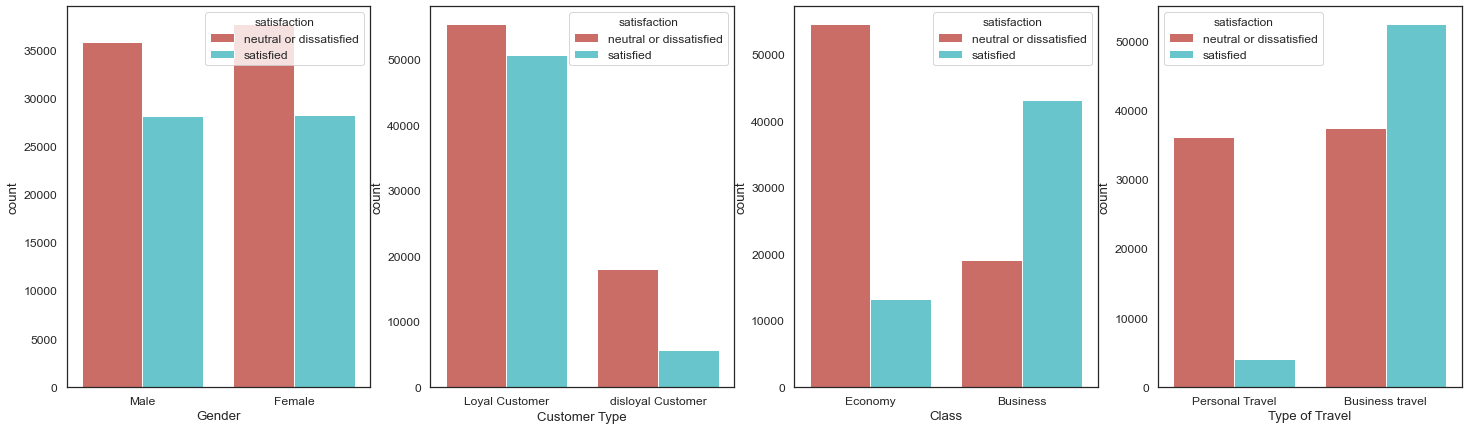

In [18]:
categorical_vars = ['Gender','Customer Type','Class','Type of Travel']
fig , ax = plt.subplots(nrows = 1, ncols = 4,figsize=(25,7))

for col,subplot in zip(categorical_vars , ax.flatten()):
    plot = sns.countplot(x=df[col], hue = df['satisfaction'], palette='hls',ax=subplot)
plt.show()

Gender wise, the distribution of satisfaction levels are almost the same.                                                       Disloyal Customers seem to be not so happy with their flying experience. The satisfaction rate is much less.     

Though the Economy class passengers are slightly more than Business class, there is a drastic difference in the satisfaction level . Economy class passengers seem to be generally less satisfied.                                                            
Passengers traveling for business needs are way too higher than those for personal needs.The business class seems to be more satisfied with the journey.

#### How important is Age as a feature to contribute for satisfaction?

Age distribution in the dataset

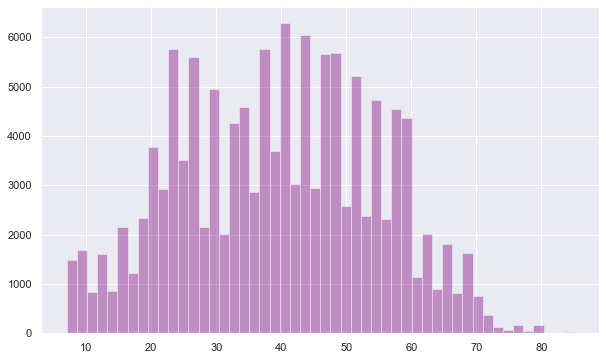

In [19]:
age = df[['Age']]
fig = plt.figure(figsize=[10,6])
sns.set(style='darkgrid',)
plot = sns.distplot(age,bins = 50,color='purple',kde=False)
plt.show()

As seen above , a fair number of passengers (>4000) belong to the age group around 40-60. Also a much younger group in the range between 20 to 30 is seen.

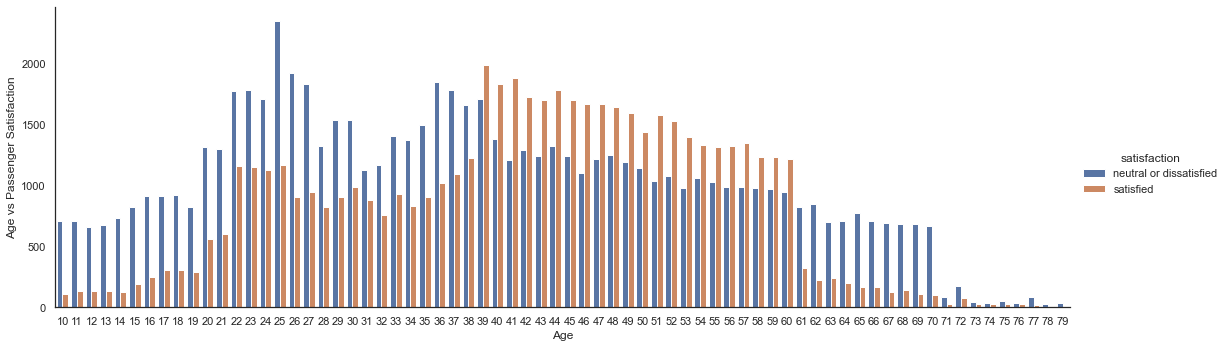

In [20]:
with sns.axes_style('white'):
    g = sns.catplot("Age", data=df, aspect=3.0, kind='count', hue='satisfaction', order=range(10, 80))
    g.set_ylabels('Age vs Passenger Satisfaction')
    sns.despine()

The elder passengers are seemingly more satisfied than the relatively same number of younger crowd. The highest level of dissatisfaction is also shown by passengers of age around 22-27.

Our Target variable is "Satisfaction" which is defined as categorical type. There are also few other variables which are categorical and need to be encoded so as to include (if required) those features for our modeling.(We don't know yet which are the best and worst features to predict the Target.)

Label Encoding of Categorical variables

In [21]:
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in df.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    df[col] = lencoders[col].fit_transform(df[col])

In [22]:
df.head(5)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Total Delay
0,0,1,0,13,1,1,460,3,4,3,...,3,5,5,4,3,4,4,5,5,43.0
1,0,1,1,25,0,0,235,3,2,3,...,3,1,1,1,5,3,1,4,1,7.0
2,1,0,0,26,0,0,1142,2,2,2,...,5,5,5,4,3,4,4,4,5,0.0
3,0,0,0,25,0,0,562,2,5,5,...,2,2,2,2,5,3,1,4,2,20.0
4,1,1,0,61,0,0,214,3,3,3,...,5,5,3,3,4,4,3,3,3,0.0


Outlier detection and Removal

In [23]:
#Q1 = df.quantile(0.25)
#Q2 = df.quantile(0.75)
#IQR = Q2 - Q1
#print(IQR)

In [24]:
# Removing outliers from dataset
#df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q2 + 1.5 * IQR))).any(axis=1)]
#df.shape

Correlation Coefficient

Check which features are having a positive corelation with the Target variable
Plotting a heatmap to find that out.

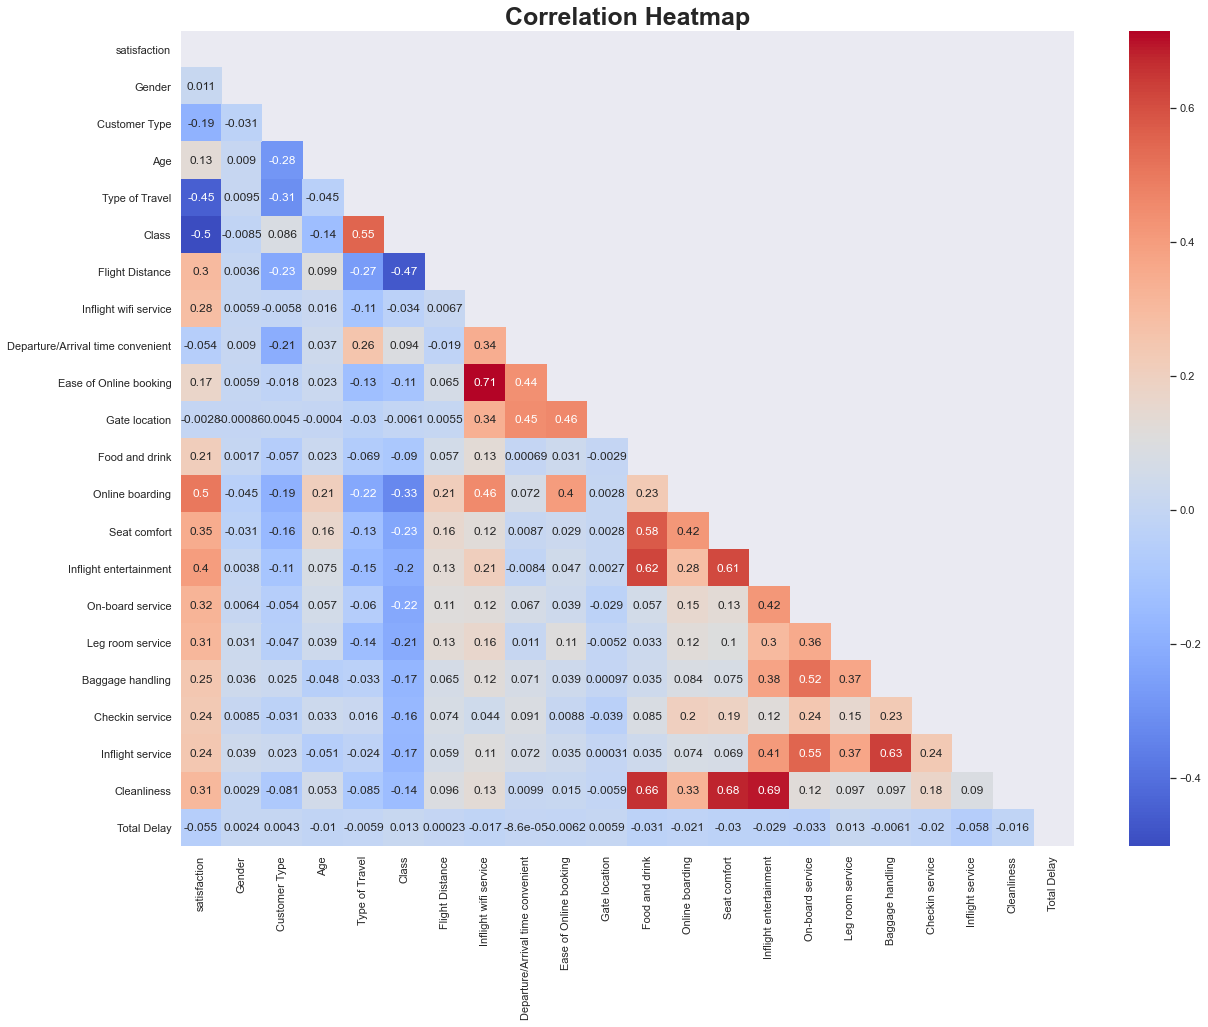

In [25]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', ax=ax)
plt.title('Correlation Heatmap', weight='bold',fontsize=25)
plt.savefig("corrmatrix.png")
plt.show()

The correlation matrix shows that there are no features which have collinearity over 90%.
The highest collinearity of 0.71 is seen between "Ease of online booking" and "Inflight wifi service".
Also, there is a good collinearity between the factors such as Cleanliness , Seat comfort ,Inflight entertainment , Inflight service , onboard service , Online boarding and Baggage handling.

It can be thought of as : Inflight service includes Inflight wifi service , Inflight entertainment , Food and drink , Leg room service and Seat comfort. Hence inorder to minimize the chance of overfitting, we might have to remove some of these similiar features.

If we consider a threshold value of 0.4 ,the prime factors leading to customer satisfation as per the correlation matrix could be summarized as:

Best features: Online boarding ,Inflight entertainment, Seat Comfort

#### Apart from analyzing the correlation matrix for feature selection, there are some other methods we can resort to , to come up with the best features which inturn can minimize the chances of overfitting.

# Feature selection using Filter method

#### 1. Filter method - Chi Square Test
We calculate Chi-square between each feature and the target and select the desired number of features with the best Chi-square scores.

In [26]:
#Normalizing data
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(df)
modified_df = pd.DataFrame(r_scaler.transform(df), columns=df.columns)
modified_df.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Total Delay
0,0.0,1.0,0.0,0.076923,1.0,1.0,0.086632,0.6,0.8,0.6,...,0.6,1.0,1.0,0.8,0.6,0.75,0.8,1.0,1.0,0.013539
1,0.0,1.0,1.0,0.230769,0.0,0.0,0.041195,0.6,0.4,0.6,...,0.6,0.2,0.2,0.2,1.0,0.50,0.2,0.8,0.2,0.002204
2,1.0,0.0,0.0,0.243590,0.0,0.0,0.224354,0.4,0.4,0.4,...,1.0,1.0,1.0,0.8,0.6,0.75,0.8,0.8,1.0,0.000000
3,0.0,0.0,0.0,0.230769,0.0,0.0,0.107229,0.4,1.0,1.0,...,0.4,0.4,0.4,0.4,1.0,0.50,0.2,0.8,0.4,0.006297
4,1.0,1.0,0.0,0.692308,0.0,0.0,0.036955,0.6,0.6,0.6,...,1.0,1.0,0.6,0.6,0.8,0.75,0.6,0.6,0.6,0.000000


In [27]:
X = modified_df.loc[:,modified_df.columns!='satisfaction']
y = modified_df[['satisfaction']]

#Feature extraction with top 10 Chi-square scores
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)

X_new = selector.transform(X)

#Summarize selected features
print(X.columns[selector.get_support(indices=True)])

Index(['Customer Type', 'Type of Travel', 'Class', 'Flight Distance',
       'Inflight wifi service', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service'],
      dtype='object')


# 2.Feature Selection using Embedded Method

#### 1. Random Forest Importance

In [28]:
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y.values.ravel())
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y.values.ravel()).feature_importances_)

['Type of Travel', 'Class', 'Inflight wifi service', 'Online boarding', 'Inflight entertainment']
[0.00419469 0.03884897 0.03110061 0.09861957 0.10507472 0.03580245
 0.15300696 0.02056689 0.04083535 0.01761168 0.01118556 0.15496757
 0.04552457 0.05861595 0.03291107 0.03745835 0.02352869 0.02556531
 0.02386602 0.02471208 0.01600295]


#### 2.LASSO (Least Absolute Shrinkage Selector Operator /L1) Regularization

Regularization consists of adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model.

In [29]:
#Normalize features
std = StandardScaler()
std.fit(X.values)
X_tr = std.transform(X.values)

lasso_model = Lasso(alpha = 0.01)    
selected_columns = list(X.columns)
lasso_model.fit(X, y)
list(zip(selected_columns, lasso_model.coef_))

[('Gender', 0.0),
 ('Customer Type', -0.19148559780009683),
 ('Age', -0.0),
 ('Type of Travel', -0.3038656435416676),
 ('Class', -0.16371932861312202),
 ('Flight Distance', 0.0),
 ('Inflight wifi service', 0.06155965816773238),
 ('Departure/Arrival time convenient', -0.0),
 ('Ease of Online booking', -0.0),
 ('Gate location', -0.0),
 ('Food and drink', 0.0),
 ('Online boarding', 0.38089733794793407),
 ('Seat comfort', 0.0),
 ('Inflight entertainment', 0.2043042654845911),
 ('On-board service', 0.11149637611409846),
 ('Leg room service', 0.1014454123623122),
 ('Baggage handling', 0.03729185453832435),
 ('Checkin service', 0.09029616328918409),
 ('Inflight service', 0.0),
 ('Cleanliness', 0.0),
 ('Total Delay', -0.0)]

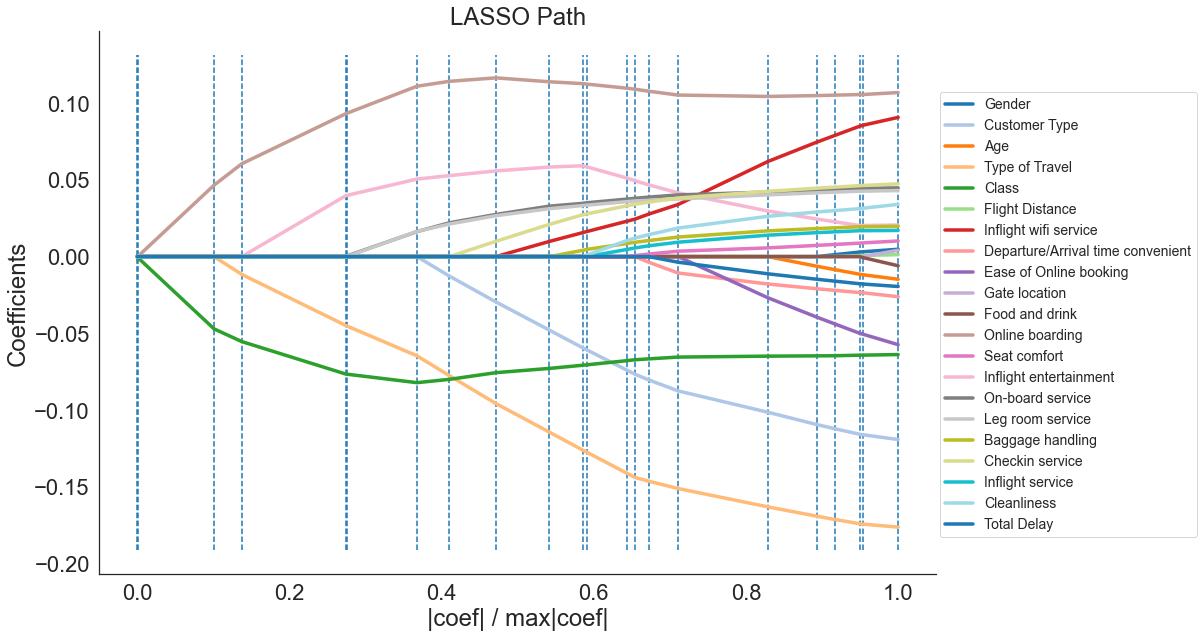

In [31]:
alphas, _, coefs = lars_path(X_tr, y.values.ravel(), method='lasso')

from cycler import cycler

# plotting the LARS path
sns.set(style='white',font_scale=2)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.rc('axes', prop_cycle =(cycler(color =['#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A',
                                            '#D62728', '#FF9896', '#9467BD', '#C5B0D5', '#8C564B', '#C49C94',
                                            '#E377C2', '#F7B6D2', '#7F7F7F', '#C7C7C7', '#BCBD22', '#DBDB8D',
                                            '#17BECF', '#9EDAE5'])))

plt.figure(figsize=(15,10))
plt.plot(xx, coefs.T,linewidth=3.5)

ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X.columns,loc="upper right", bbox_to_anchor=(1.32, 0.9),fontsize=14)
sns.despine()
plt.savefig('lassoplot.png',transparent=True, bbox_inches='tight')

The coefficiients that shrink to zero faster indicate less feature importance.
From the plot, the identified features are Food and drink ,Gender, Age, Gate location, and Flight distance.

# 3.Feature selection using Wrapper method

### 1.Recursive Feature Elimination (RFE)
This method works by recursively removing attributes and building a model on those attributes that remain.
It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

We will try using RFE with logistic regression classifier to select the top 5 features.

In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Feature extraction
model = LogisticRegression()
rfe = RFE(model, 5)
fit = rfe.fit(X, y.values.ravel())
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

c:\users\gurur\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Num Features: 5
Selected Features: [False  True False  True False False False False False False False  True
 False False  True False False False False False  True]
Feature Ranking: [17  1 10  1  8 16  6  9  7 15 14  1 12 13  1  3 11  2  5  4  1]


RFE chose the top 5 features as 'Type of Travel','Online boarding','Onboard service','leg room service' and 'Cleanliness' which are marked as True in the support array and choice 1 in the Ranking list.
This inturn indicates the strength of these features.

Generalizing and putting it all together from the above feature selection techniques ,it can be concluded that certain features do not contribute to the model prediction and hence can be removed from the dataset for further use.
### Worst features : Age , Gender ,Gate location , Total Delay , Departure/Arrival time Convenient. 
That leaves us with a total of 17 features to model.

In [33]:
df = df.drop(['Gender','Total Delay','Age','Gate location','Departure/Arrival time convenient'],axis=1)

# Modelling and Evaluation

Let's now train the following models on this dataset to predict the satisfaction of customers and then evaluate their performance by comparing using different metrics ROC_AUC , Cross validation scores and confusion matrix.
We will make use of the following classification algorithms to create our models :
1. Logistic Regression
2. Gaussian Naive-Bayes 
3. K-Nearest Neighbour 
4. Decision Tree
5. Random Forest Classifier


First I will split the dataset using the default approach : 80% for training and 20% for testing.
And then try splitting the data using k-Fold Cross validation.

#### Simple split - Train Test Split 

In [34]:
y = df['satisfaction']
X = df.drop('satisfaction',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [35]:
#Feature Scaling 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [36]:
# Defining a function to build the 5 models iteratively , plot the confusion matrix , ROC curve and returns the evaluation metrics :Accuracy score, ROC Area under the curve , Time taken  
# for each of the model.

In [37]:
import time
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve
from matplotlib import pyplot as plt 
def build_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train.ravel(), verbose=0)
    else:
        model.fit(X_train,y_train.ravel())
        
    #Predict the model  
    y_pred = model.predict(X_test)
    
    #Fitting the model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    time_taken = time.time()-t0
    
    #Print the evaluation metrics : Precision,Recall,F1 score, Accuracy score, ROC curve,Time taken 
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    #plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.pink, normalize = 'all')
    cm = confusion_matrix(y_test, y_pred)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Satisfied/Not Satisfied: Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

    return model, accuracy, roc_auc, time_taken

#### Model1 :Gaussian Naive Bayes

Accuracy = 0.8654527255928549
ROC Area under Curve = 0.860410023268053
Time taken = 0.05987143516540527
              precision    recall  f1-score   support

           0    0.86585   0.90049   0.88283     14622
           1    0.86489   0.82033   0.84202     11354

    accuracy                        0.86545     25976
   macro avg    0.86537   0.86041   0.86243     25976
weighted avg    0.86543   0.86545   0.86499     25976



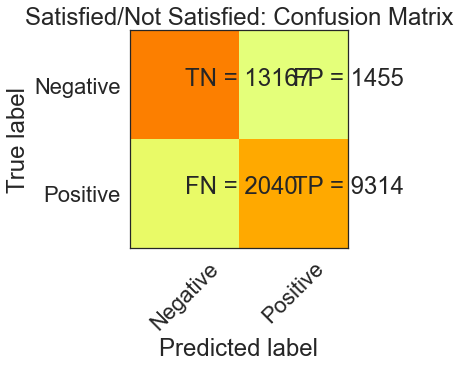

In [38]:
from sklearn.naive_bayes import GaussianNB

params_nb = {}

model_nb = GaussianNB(**params_nb)
model_nb, acc_nb, roc_auc_nb, tt_nb = build_model(model_nb, X_train, y_train, X_test, y_test)

#### Model2 :Logistic Regression

Accuracy = 0.874153064367108
ROC Area under Curve = 0.8699392442471423
Time taken = 0.13351893424987793
              precision    recall  f1-score   support

           0    0.87675   0.90343   0.88989     14622
           1    0.87057   0.83645   0.85316     11354

    accuracy                        0.87415     25976
   macro avg    0.87366   0.86994   0.87153     25976
weighted avg    0.87405   0.87415   0.87384     25976



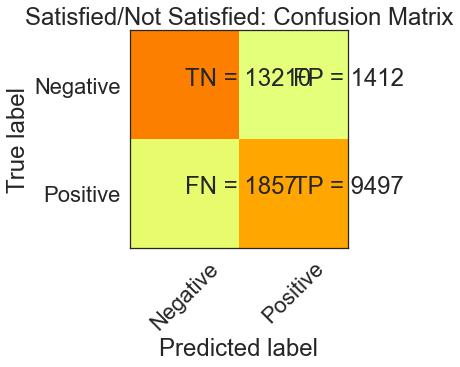

In [39]:
#params_lr = {'penalty': 'elasticnet', 'l1_ratio':0.5, 'solver': 'saga'}

model_lr = LogisticRegression(max_iter=1000)
model_lr, accuracy_lr, roc_auc_lr, tt_lr = build_model(model_lr, X_train, y_train, X_test, y_test)

#### Model3: KNearest Neighbors

Accuracy = 0.9324376347397598
ROC Area under Curve = 0.9256868349870196
Time taken = 13.358123302459717
              precision    recall  f1-score   support

           0    0.90788   0.97935   0.94226     14622
           1    0.97040   0.87203   0.91859     11354

    accuracy                        0.93244     25976
   macro avg    0.93914   0.92569   0.93042     25976
weighted avg    0.93521   0.93244   0.93191     25976



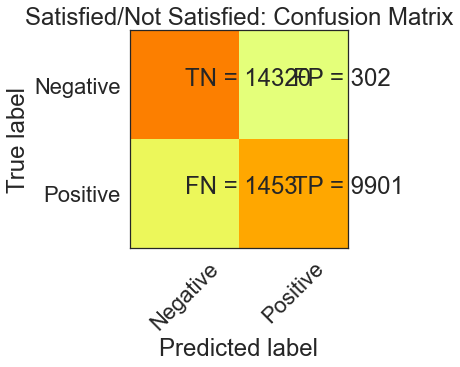

In [40]:
params_kn = {'n_neighbors':10, 'algorithm': 'kd_tree', 'n_jobs':4}

model_kn = KNeighborsClassifier(**params_kn)
model_kn, accuracy_kn, roc_auc_kn, tt_kn = build_model(model_kn, X_train, y_train, X_test, y_test)

#### Model4: Decision Tree Classifier

Accuracy = 0.9420234062211272
ROC Area under Curve = 0.9390536535671622
Time taken = 0.12025833129882812
              precision    recall  f1-score   support

           0    0.93615   0.96266   0.94922     14622
           1    0.95009   0.91545   0.93245     11354

    accuracy                        0.94202     25976
   macro avg    0.94312   0.93905   0.94083     25976
weighted avg    0.94225   0.94202   0.94189     25976



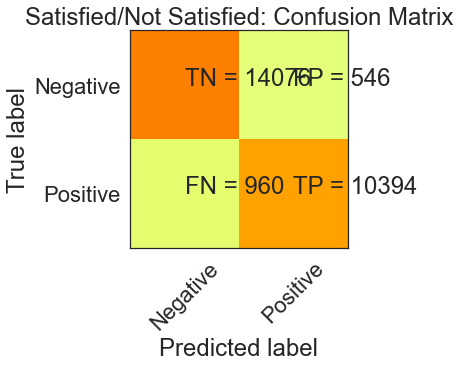

In [41]:
from sklearn.tree import DecisionTreeClassifier
params_dt = {'max_depth': 12,    
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, tt_dt = build_model(model_dt, X_train, y_train, X_test, y_test)

#### Model5 : Random Forest Classifier

Accuracy = 0.960655990144749
ROC Area under Curve = 0.9577201505174843
Time taken = 8.851425647735596
              precision    recall  f1-score   support

           0    0.95063   0.98106   0.96560     14622
           1    0.97455   0.93438   0.95405     11354

    accuracy                        0.96066     25976
   macro avg    0.96259   0.95772   0.95982     25976
weighted avg    0.96109   0.96066   0.96055     25976



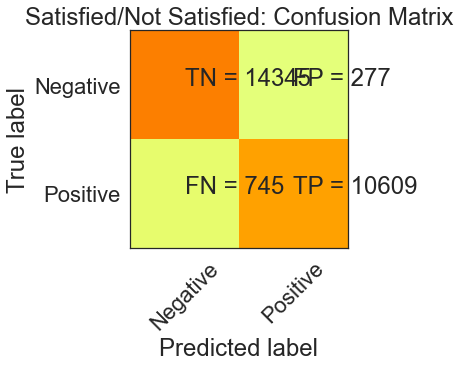

In [42]:
params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = rf(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, tt_rf = build_model(model_rf, X_train, y_train, X_test, y_test)

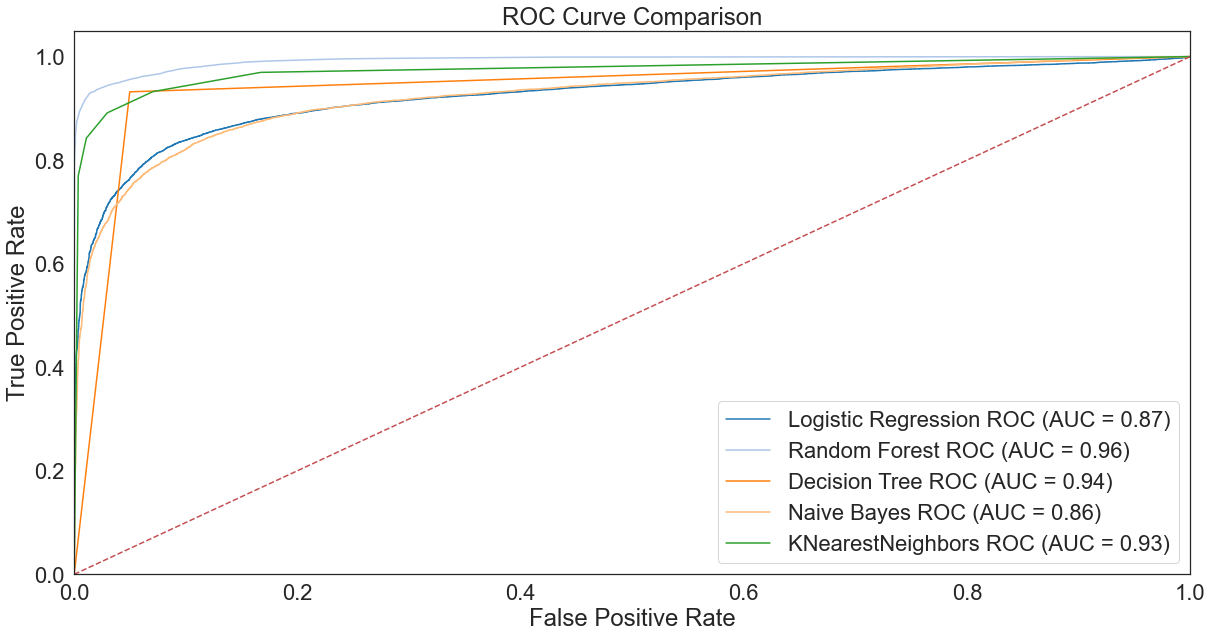

In [43]:
plt.figure(figsize=(20,10))
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Random Forest',
    'model': rf(),
},
{
    'label': 'Decision Tree',
    'model': DecisionTreeClassifier(),
},
{
    'label': 'Naive Bayes',
    'model': GaussianNB(),
},  
{
    'label': 'KNearestNeighbors',
    'model': KNeighborsClassifier(),
}, 

]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()   # Display  

RandomForestClassifier outperforms all the other models in terms of Precision , Recall and AUC.                                 

Under this paradigm, having high Precision will be more important for our business problem. To correctly identify the crucial factors leading to customer satisfaction, the model prediction of the positive class, ‘Satisfied’ needs to be very reliable.

#### Optimizing the model with kFold CrossValidation Technique

Splitting the training data into 5-folds(subset). We then average the scores of our models against each of the folds and finalize our model.After that we test with the test data.                                                                            
In simple words ,Instead of training and evaluating the data once on just one train and test set(as in the simple train-test split method),in this splitting strategy we try out various possible combinations of split data which produces results of each split test score(CV score) as output. Hyperparameter tuning is also done to determine the optimal values of K(in KNN), max_depth score for DecisionTree and Random Forest classifiers.

This gives a more accurate representation of our prediction.

In [44]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

Calculate mean AUC, Precision and Recall scores of all the models.

1.Logistic Regression

In [45]:
mod_lr = LogisticRegression(max_iter=10000)
Mean_AUC_lr_CV = np.mean(cross_val_score(mod_lr, X_train_val, y_train_val.values.ravel(), cv=kf, scoring='roc_auc'))
Mean_Precision_lr_CV = np.mean(cross_val_score(mod_lr, X_train_val, y_train_val.values.ravel(), cv=kf, scoring='precision'))
Mean_Recall_lr_CV = np.mean(cross_val_score(mod_lr, X_train_val, y_train_val.values.ravel(), cv=kf, scoring='recall'))

print(Mean_AUC_lr_CV)
print(Mean_Precision_lr_CV)
print(Mean_Recall_lr_CV)

0.9245158769982023
0.8658453973435243
0.8340717591638427


In [46]:
X_train_val = X_train_val.reset_index().drop('index',axis=1)
y_train_val = y_train_val.reset_index().drop('index',axis=1)

Gaussian NB

In [47]:
Mean_AUC_nb_CV = np.mean(cross_val_score(GaussianNB(), X_train_val, y_train_val.values.ravel(), cv=kf, scoring='roc_auc'))
Mean_Precision_nb_CV = np.mean(cross_val_score(GaussianNB(), X_train_val, y_train_val.values.ravel(), cv=kf, scoring='precision'))
Mean_Recall_nb_CV = np.mean(cross_val_score(GaussianNB(), X_train_val, y_train_val.values.ravel(), cv=kf, scoring='recall'))
print(Mean_AUC_nb_CV)
print(Mean_Precision_nb_CV)
print(Mean_Recall_nb_CV)

0.9252011954904678
0.8629596228420636
0.8204402831414275


The following code fragments have been executed few times to determine the optimal value of K and max_depth. Since it consumes more computation time for tuning with various values, the code has been commented out after obtaining the highest possible score for the model. 

The optimum hyperparameters obtained are:                      

1.k-Nearest neighbors: k= 7                                                                                                      
2.Decision Tree :Max depth = 14                                                                                                        
3.Random Forest: Max depth = 18


In [ ]:
#Hyperparameter tuning to find out optimum K-value

#List Hyperparameters that we want to tune.
'''''n_neighbors = list(range(7,11))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=5)
#Fit the model
best_model = clf.fit(X_train_val,y_train_val)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])'''''


#Best n_neighbors: 7

In [ ]:
#Hyperparameter tuning for DecisionTree (to get ideal value of maximum depth)
'''''score = []
for depth in range(5,20):
    f1 = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=depth), X_train_val, y_train_val, cv=kf, scoring='f1'))
    score.append(f1)
best_depth = list(range(5,20))[np.argmax(score)]  
best_f1 = max(score)
print('The best depth is {0} with f1-score of {1}'.format(best_depth,best_f1))'''''

#Best depth is 14 with f1 score of 0.9445151851059036

In [ ]:
#Hyperparameter tuning for RandomForest (to get ideal value of maximum depth)
'''''parameters = {'bootstrap': [True],
     'max_depth': [12, 18],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [3, 5],
     'min_samples_split': [4, 6],
     'n_estimators': [100, 350]
    }
     
RF = rf()

forest_grid_search = GridSearchCV(RF, parameters, cv=5,
                                  scoring="f1",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)
forest_grid_search.fit(X_train_val, y_train_val)
forest_grid_search.best_estimator_
forest_grid_search.best_score_ '''''

# We got a best accuracy score of 95.4% for max_depth=18

In [49]:
Mean_AUC_KNN_CV = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=7), X_train_val, y_train_val.values.ravel(), cv=kf, scoring='roc_auc'))
Mean_Precision_KNN_CV = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=7), X_train_val, y_train_val.values.ravel(), cv=kf, scoring='precision'))
Mean_Recall_KNN_CV = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=7), X_train_val, y_train_val.values.ravel(), cv=kf, scoring='recall'))
print(Mean_AUC_KNN_CV)
print(Mean_Precision_KNN_CV)
print(Mean_Recall_KNN_CV)

#0.9164883970544991
#0.8688126272067589
#0.7725995511973955

0.9164883970544991
0.8688126272067589
0.7725995511973955


In [50]:
Mean_AUC_DT_CV = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=14), X_train_val, y_train_val.values.ravel(), cv=kf, scoring='roc_auc'))
Mean_Precision_DT_CV = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=14), X_train_val, y_train_val.values.ravel(), cv=kf, scoring='precision'))
Mean_Recall_DT_CV = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=14), X_train_val, y_train_val.values.ravel(), cv=kf, scoring='recall'))
print(Mean_AUC_DT_CV)
print(Mean_Precision_DT_CV)
print(Mean_Recall_DT_CV)

#0.9766382479990379
#0.9621642927255584
#0.9278717525734945

0.9765581730001923
0.9619497894240829
0.9277378099504473


In [52]:

Mean_AUC_RF_CV = np.mean(cross_val_score(rf(max_depth=18,random_state=42), X_train_val, y_train_val.values.ravel(), cv=kf, scoring='roc_auc'))
Mean_Precision_RF_CV = np.mean(cross_val_score(rf(max_depth=18,random_state=42), X_train_val, y_train_val.values.ravel(), cv=kf, scoring='precision'))
Mean_Recall_RF_CV = np.mean(cross_val_score(rf(max_depth=18,random_state=42), X_train_val, y_train_val.values.ravel(), cv=kf, scoring='recall'))
print(Mean_AUC_RF_CV)
print(Mean_Precision_RF_CV)
print(Mean_Recall_RF_CV)

#0.9931665276511137
#0.9713979498206301
#0.9380162211624222

0.9931665276511137
0.9713979498206301
0.9380162211624222


In [53]:
#Representing the scores of different models as columns in a dataframe for ease of comparison.
model = ['Logistic Regression','KNN','Gaussian NB','Decision Trees','Random Forest']
scoring = ['AUC','Precision','Recall']
model_name = ['lr','KNN','nb','DT','RF']
model_list = []

for i in model:
    for j in scoring:
        model_dic = {'Model': i,'Scoring':j, 'Score':eval('Mean_{0}_{1}_CV'.format(j,model_name[model.index(i)]))}
        model_list.append(model_dic)

model_df = pd.DataFrame(model_list)
model_df

,Model,Scoring,Score
0,Logistic Regression,AUC,0.924516
1,Logistic Regression,Precision,0.865845
2,Logistic Regression,Recall,0.834072
3,KNN,AUC,0.916488
4,KNN,Precision,0.868813
5,KNN,Recall,0.772600
6,Gaussian NB,AUC,0.925201
7,Gaussian NB,Precision,0.862960
8,Gaussian NB,Recall,0.820440
9,Decision Trees,AUC,0.976558


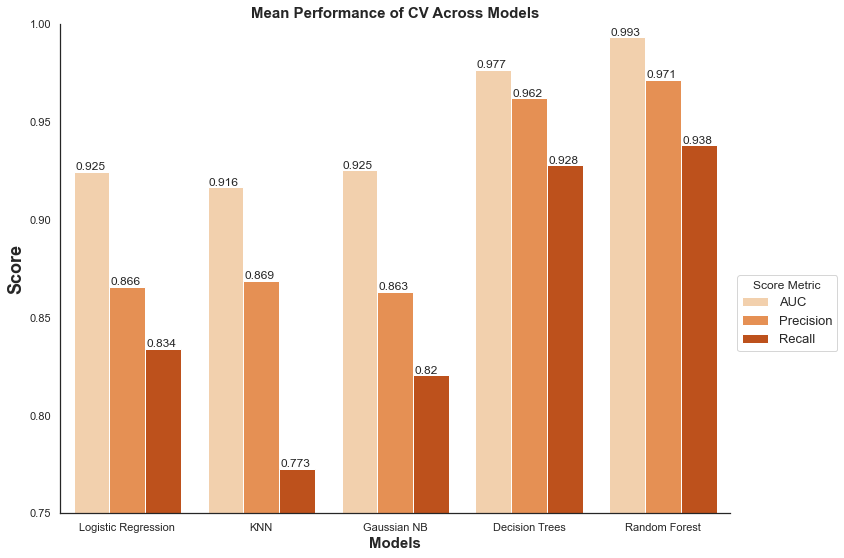

In [54]:
sns.set(style='white',font_scale=1)
fig = plt.figure(figsize=[12,9])
ax = sns.barplot(x='Model',y='Score',data=model_df,hue='Scoring',palette='Oranges')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.01, p.get_height()+0.001))
plt.legend(title='Score Metric',loc="upper right", bbox_to_anchor=(1.17, 0.5),fontsize=13)
plt.ylim([0.8,1.0])
plt.yticks([0.75,0.80,0.85,0.90,0.95,1.00])
plt.xlabel('Models',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Mean Performance of CV Across Models',weight='bold',fontsize=15)
sns.despine()
plt.savefig('modelbarplot.png',transparent=True, bbox_inches='tight')

Upon comparing the cross validation scores of all these models, it can be seen that RandomForestClassifier is the best performed model (in terms of its AUC,Precision and Recall) to proceed with the final prediction of the target variable with our unseen test data.

Considering the metrics,DecisionTree Classifier is also a good model to consider . Either we can ensemble both of them(combine both DT and RF using Votingclassifier method) or RF alone with its default probability threshold value and the obtained hyperparameter values found using the GridSearchCV algorithm. I'll do the latter.

#### So, the model selected is RandomForestClassifier (max_depth = 18 with default threshold of 0.5).

#### Training the chosen model i.e RandomForestClassifier on 80% of the data

In [55]:
RF = rf(max_depth=18,random_state=42)
RF.fit(X_train_val,y_train_val.values.ravel())
print("Random Forest model Accuracy score for trained data: {:.4f}".format(RF.score(X_train_val,y_train_val)))

Random Forest model Accuracy score for trained data: 0.9815


#### Final Model Prediction and Evaluation with Test data

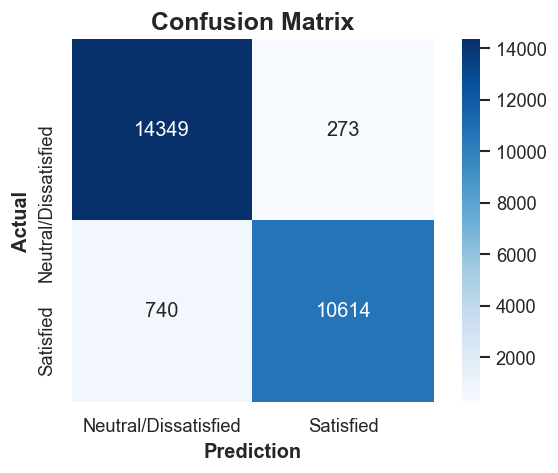

In [56]:
def create_confusion_matrix(model, threshold=0.5):
    y_predict = model.predict(X_test)
    cnf = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=120)
    ax = sns.heatmap(cnf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Neutral/Dissatisfied', 'Satisfied'],
           yticklabels=['Neutral/Dissatisfied', 'Satisfied']);   
    plt.xlabel('Prediction',weight='bold',fontsize=12)
    plt.ylabel('Actual',weight='bold',fontsize=12)
    plt.title('Confusion Matrix',weight='bold',fontsize=15)

sns.set(style='white',font_scale=1)
create_confusion_matrix(RF)
plt.savefig('confusionplot.png',transparent=True, bbox_inches='tight')

In [57]:
y_predict = RF.predict(X_test)

print("Precision of prediction is:",precision_score(y_test,y_predict))
print("Recall of prediction is",recall_score(y_test,y_predict))
print("f1 score of prediction is",f1_score(y_test,y_predict))
print("AUC of predicted data is" ,roc_auc_score(y_test,y_predict))
print(classification_report(y_test,y_predict))


Precision of prediction is: 0.974924221548636
Recall of prediction is 0.9348247313722037
f1 score of prediction is 0.9544534868036509
AUC of predicted data is 0.9580771174300493
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     14622
           1       0.97      0.93      0.95     11354

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976



So, we can conclude the Random Forest algorithm has the score to correctly predict this data with 95% to detect “neutral or dissatisfied” & 97% to detect “satisfied”. 

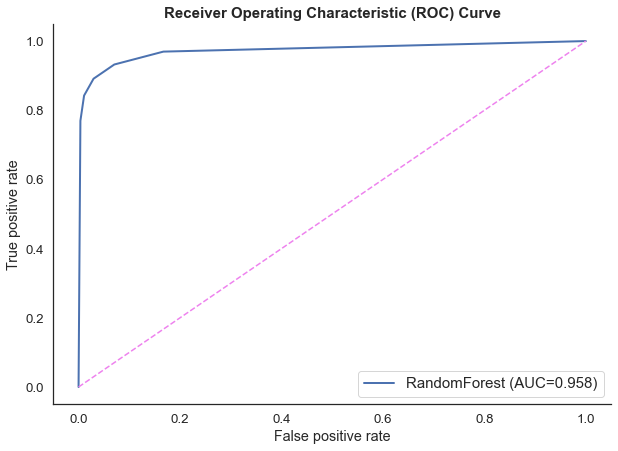

In [58]:
sns.set(style='white',font_scale=1.2)
fig = plt.figure(figsize=[10,7])
plt.plot(fpr, tpr,lw=2,label='RandomForest (AUC={:.3f})'.format(roc_auc_score(y_test,y_predict)))
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc="lower right",fontsize=15)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic (ROC) Curve',weight='bold',fontsize=15);
sns.despine()
plt.savefig('ROCplot.png',transparent=True, bbox_inches='tight')

Business problem - Feature importance on trained data

In [59]:
RF.feature_importances_

array([0.04312978, 0.10095613, 0.12158811, 0.03294115, 0.16233907,
       0.04098674, 0.01145506, 0.20656796, 0.04588308, 0.07199222,
       0.0308997 , 0.03526922, 0.02562198, 0.02455643, 0.0222852 ,
       0.02352817])

In [64]:
df_impt = pd.DataFrame({'features':X_train_val.columns,'importance':RF.feature_importances_})
df_impt = df_impt.sort_values(by='importance',ascending=True)
df_impt

,features,importance
6,Food and drink,0.011455
14,Inflight service,0.022285
15,Cleanliness,0.023528
13,Checkin service,0.024556
12,Baggage handling,0.025622
10,On-board service,0.030900
3,Flight Distance,0.032941
11,Leg room service,0.035269
5,Ease of Online booking,0.040987
0,Customer Type,0.043130


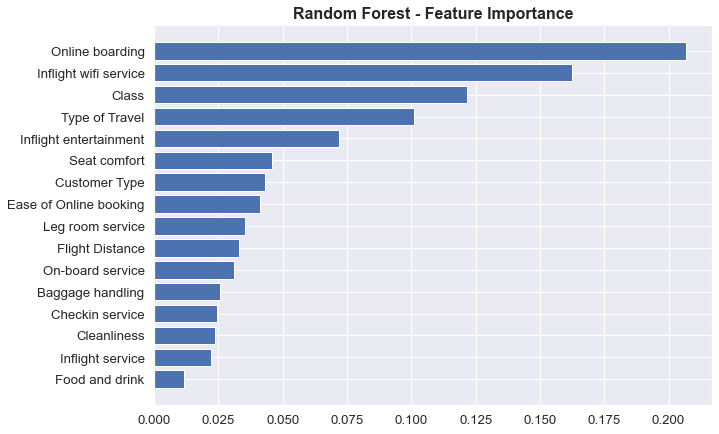

In [65]:
sns.set(style='darkgrid',font_scale=1.2)
fig = plt.figure(figsize=[10,7])
ax = plt.barh(df_impt['features'],df_impt['importance'])
plt.title('Random Forest - Feature Importance',weight='bold',fontsize=16)
plt.savefig('featureplot.png')


# Conclusions
DecisionTree and RandomForest are good choices of model to predict the target variable.
RandomForest has been proved to have a more higher accuracy score , higher precision ,recall and AUC values.

As what has been understood from the data earlier, there's a domination of loyal customers over disloyal customers.
The "loyal" passengers must be the ones who already have prior flying experience with the airlines and that explains why this group is highly satisfied.

The airline must focus the 'disloyal'or rather new customers to earn their satisfaction. 

Airlines better give more attention to the needs of Economy class so as to improve the satisfaction factor.

Online booking and Inflight wifi service also could be improved to gain more satisfaction among the Economy class.


